# Analiza - sprawdzenie bardzo prostej strategii opartej jedynie na formacjach świecowych + "zasada 11/20"

In [1]:
import pandas as pd
import pandas_datareader.data as web
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import glob, os.path
sns.set_style('whitegrid')
%matplotlib inline

In [2]:
eurusd = pd.read_csv('data/EURUSD60.csv',
                   names=['day', 'hour', 'open', 'high', 'low', 'close', 'volume'], index_col=False)
eurusd['date'] = pd.DatetimeIndex(eurusd.day + ' ' + eurusd.hour)
del eurusd['day']
del eurusd['hour']
eurusd.set_index('date', inplace=True)
eurusd.info()

eurusd.ix['2017-06-23 23:00']

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2451 entries, 2017-02-01 21:00:00 to 2017-06-23 23:00:00
Data columns (total 5 columns):
open      2451 non-null float64
high      2451 non-null float64
low       2451 non-null float64
close     2451 non-null float64
volume    2451 non-null int64
dtypes: float64(4), int64(1)
memory usage: 114.9 KB


open         1.11964
high         1.11973
low          1.11914
close        1.11923
volume    1093.00000
Name: 2017-06-23 23:00:00, dtype: float64

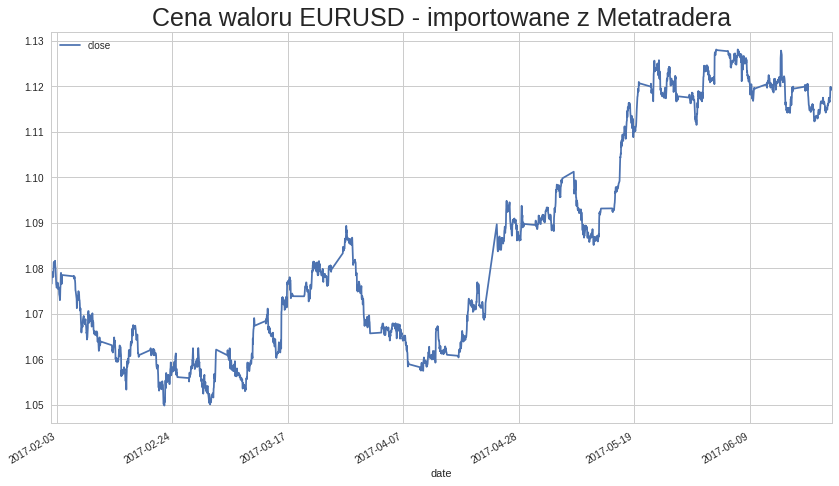

In [42]:
eurusd['close'].plot(legend=True,figsize=(14,8))
plt.title('Cena waloru EURUSD - importowane z Metatradera', fontsize=25)

In [4]:
def ohlc(r):
    return r['open'], r['high'], r['low'], r['close']

## Wczytanie specyfikacji wszystkich instrumentów

Specyfikacja instrumentów wygenerowana w MetaTraderze skryptem MQL allmarketdata.ex4

In [6]:
specs = pd.read_csv('instruments.csv', sep=';', index_col=0)

# XXX - nie da się tego wyciągnąć bezpośrednio ze specyfikacji ??
def setPipSize(x):
    return float(x['Tick Size']) # XXX - uproszczenie, nie jestem pewien, czy to jest prawidłowe
    if x['Pr. Mode'] == 'Forex':
        if x['Symbol'].endswith('JPY'):
            return 0.01
        # elif x['Symbol'].endswith('HUF'):  # XXX Forint ???
        return 0.0001
    return 1
specs['Pip'] = specs.apply(setPipSize, axis=1)

specs

,Description,Digits,Spread,Swap Long,Swap Short,Swap Type,Stop Level,Lot Size,Lot Min,Lot Step,Tick Value,Tick Size,Trade Allowed,Pr. Mode,Pip
Symbol,,,,,,,,,,,,,,,
AUDCAD,AUSTRALIAN DOLLAR VS CANADIAN DOLLAR,5,32,-0.90,-8.19,points,160,100000,0.01,0.01,2.839511,0.00001,yes,Forex,0.00001
AUDCHF,Australian Dollar vs Swiss Franc,5,36,2.21,-8.89,points,160,100000,0.01,0.01,3.871266,0.00001,yes,Forex,0.00001
AUDJPY,Australian Dollar vs Japanise Yen,3,29,0.76,-8.44,points,99,100000,0.01,0.01,3.370140,0.00100,yes,Forex,0.00100
AUDNZD,Australian Dollar vs New Zealand Dollar,5,41,-4.82,-4.62,points,210,100000,0.01,0.01,2.742852,0.00001,yes,Forex,0.00001
AUDUSD,Australian Dollar vs US Dollar,5,19,-1.07,-3.73,points,50,100000,0.01,0.01,3.756560,0.00001,yes,Forex,0.00001
CADCHF,Canadian Dollar vs Swiss Franc,0,0,-0.14,-5.95,points,180,100000,0.01,0.01,0.000000,0.00001,yes,Forex,0.00001
CADJPY,Canadian Dollar vs Japanise Yen,3,32,-2.47,-4.97,points,100,100000,0.01,0.01,3.370140,0.00100,yes,Forex,0.00100
CHFJPY,Swiss Franc vs Japanise Yen,0,0,-7.32,-2.74,points,120,100000,0.01,0.01,0.000000,0.00100,yes,Forex,0.00100
CHFSGD,Swiss Franc vs Singapore Dollar,0,0,-14.68,-2.28,points,280,100000,0.01,0.01,0.000000,0.00001,yes,Forex,0.00001


### Wczytanie historycznych danych wszystkich walorów do klasy Instrument

In [7]:
class Instrument:
    def __init__(self, name):
        self.name = name
        self.spec = None
        self.data = pd.read_csv('data/%s60.csv' % name, index_col = False,
                   names=['day', 'hour', 'open', 'high', 'low', 'close', 'volume'])
        self.data['date'] = pd.DatetimeIndex(self.data.day + ' ' + self.data.hour)
        del self.data['day']
        del self.data['hour']
        self.data.set_index('date', inplace = True)
    
    def __str__(self):
        s = self.name
        if self.data is not None:
            s = s + ' ' + str(self.data.shape)
        return s

INSTRUMENTS = {}        
        
for f in glob.glob('data/*60.csv'):
    name = os.path.basename(f).replace('60.csv', '')
    inst = Instrument(name)
    inst.spec = specs.ix[name]
    INSTRUMENTS[name] = inst
 

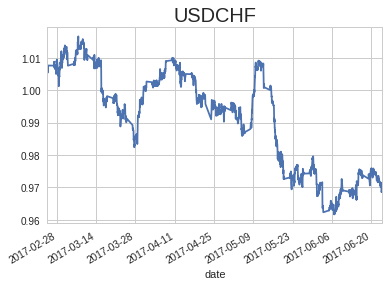

In [43]:
INSTRUMENTS['USDCHF'].data['close'].plot()
plt.title('USDCHF', fontsize=20)

## Zasada 11 / 20 - porównanie rozmiaru świecy z 20 poprzednimi

In [9]:
def zasada1120(inst, t):
    
    BACKSIZE = 20         # XXX Wyciągnąć gdzieś do konfiguracji
    CANDLES_REQUIRED = 11 # XXX
    
    t = pd.Timestamp(t)
    i = inst.data.index.get_loc(t, 'nearest')
    o, h, l, c = ohlc(inst.data.iloc[i])
    size = h - l
   
    j = 1
    smaller_candles = 0
    while j <= BACKSIZE and i - j >= 0 and smaller_candles < CANDLES_REQUIRED:
        o, h, l, c = ohlc(inst.data.iloc[i - j])
        if size > h - l:
            smaller_candles += 1
        j += 1
    if smaller_candles >= CANDLES_REQUIRED:
        return True
    
    return False
    
zasada1120(INSTRUMENTS['US30Cash'], '2017/06/20 22:00')

True

## Sprawdzanie, czy dany sygnał był prawidłowy(czy zarobił) -- B. WAŻNY FRAGMENT
### (ta funkcja docelowo byłaby jednym z głównych elementów pełnego symulatora)

In [37]:
# returns:
#   (PROFIT/LOSS, gain value, nswaps, sp, tp, size)
def sprawdz(inst, t, buysell = 'buy'):
    t = pd.Timestamp(t)
    i = inst.data.index.get_loc(t, 'nearest')
    o, h, l, c = ohlc(inst.data.iloc[i])
    size = h - l
    
    spread = 3 # XXX  US30
    spread = 0.0003 # XXX EURUSD
    spread = float(inst.spec['Spread']) / 10**int(inst.spec['Digits'])  # XXX
    #print(spread)
    PROFIT_TO_RISK = 3  # XXX Wyciagnac do konfiguracji
    
    if buysell == 'buy':
        sl = l - inst.spec['Pip'] # 1 punkt pod formacja
        risk = c - sl + spread # -> mozliwa strata = roznica poziomow + spread
        tp = c + spread + risk * PROFIT_TO_RISK # -> mozliwy zysk = roznica poziomow - spread = risk*PTR
    elif buysell == 'sell':
        sl = h + inst.spec['Pip'] + spread # 1 punkt nad formacja + spread (chyba z zalozenia ze spada szybciej)
        risk = sl - c + spread # mozliwa strata = roznica poziomow + spread
        tp = c - risk * PROFIT_TO_RISK - spread  # -> mozliwy zysk = roznica poziomow - spread = risk*PTR
    else:
        raise Exception('buysell')
    # print(sl, tp)
    
    before_midnght = inst.data.index[i].hour > 12
    nswaps = 0
    while i < inst.data.shape[0] - 1:
        i += 1
        o, h, l, c = ohlc(inst.data.iloc[i])
        
        if before_midnght and inst.data.index[i].hour < 12:
            # print('SWAP')
            nswaps += 1
        before_midnght = inst.data.index[i].hour > 12
        
        result = None
        if (buysell == 'buy' and h >= tp) or (buysell == 'sell' and l <= tp):
            # print(inst.data.index[i])
            result = 'PROFIT'
        if (buysell == 'buy' and l <= sl) or (buysell == 'sell' and h >= sl):
            # print(inst.data.index[i])
            if result == 'PROFIT':
                return 'Unknown'
            result = 'LOSS'
        if result == 'PROFIT':
            return result, PROFIT_TO_RISK * risk, nswaps, sl, tp, size #, zasada1120(inst, t)
        if result == 'LOSS':
            return result, -risk, nswaps, sl, tp, size #, zasada1120(inst, t)

t = '2017/06/22 01:00'
print(sprawdz(INSTRUMENTS['EURUSD'], t))

('LOSS', -0.00033000000000009454, 0, 1.1164399999999999, 1.1177600000000003, 0.00029000000000012349)


## Analiza młotków

In [34]:
def jestMlotek(row):
    o = row['open']
    h = row['high']
    l = row['low']
    c = row['close']
    if c > o and c - o <= 0.4 * (h - l):
        if h - c <= 0.14 * (h - l):
            return True
    if c < o and o - c <= 0.4 * (h - l):
        if h - o <= 0.14 * (h - l):
            return True    
    return False


inst = INSTRUMENTS['EURUSD']

stats = {}
balance = 0.
for idx, row in inst.data['2017/01/01':'2017/07/01'].iterrows():
    if jestMlotek(row) and zasada1120(inst,idx):
        res = sprawdz(inst, idx)
        if not res:
            print(idx, ' ', res)
            continue        
        print(idx, ' ', '%6s'%res[0], ' ', end='')
        for _ in res[1:]:
            print('%.5f'%_, ' ', end='')
        print()
        if type(res) == tuple:
            balance += res[1] # + res[2]
            if res[0] not in stats:
                stats[res[0]] = 0
            stats[res[0]] += 1
print(balance)
print(stats)
print("Success rate: %.2f%%" % (100.0*stats['PROFIT']/ sum(stats.values())))

2017-02-03 18:00:00     LOSS  -0.00160  0.00000  1.07759  1.08399  0.00158  
2017-02-06 17:00:00     LOSS  -0.00275  1.00000  1.07124  1.08224  0.00268  
2017-02-07 10:00:00     LOSS  -0.00145  0.00000  1.06606  1.07186  0.00226  
2017-02-07 15:00:00     LOSS  -0.00132  0.00000  1.06636  1.07164  0.00140  
2017-02-08 17:00:00     LOSS  -0.00222  0.00000  1.06858  1.07746  0.00217  
2017-02-10 16:00:00     LOSS  -0.00163  1.00000  1.06069  1.06721  0.00167  
2017-02-22 12:00:00     LOSS  -0.00139  0.00000  1.04933  1.05489  0.00164  
2017-02-23 09:00:00     LOSS  -0.00180  0.00000  1.05372  1.06092  0.00224  
2017-02-24 12:00:00     LOSS  -0.00110  0.00000  1.05824  1.06264  0.00112  
2017-02-28 02:00:00   PROFIT  0.00354  0.00000  1.05685  1.06157  0.00164  
2017-03-01 10:00:00     LOSS  -0.00211  0.00000  1.05249  1.06093  0.00202  
2017-03-02 14:00:00     LOSS  -0.00133  0.00000  1.05074  1.05606  0.00144  
2017-03-08 14:00:00     LOSS  -0.00109  0.00000  1.05480  1.05916  0.00132  


## Spadające gwiazdy

In [35]:
def jestSpadajacaGwiazda(row):
    o = row['open']
    h = row['high']
    l = row['low']
    c = row['close']
    if c > o and c - o <= 0.4 * (h - l):
        if o - l <= 0.14 * (h - l):
            return True
    if c < o and o - c <= 0.4 * (h - l):
        if c - l <= 0.14 * (h - l):
            return True    
    return False

inst = INSTRUMENTS['US30Cash']

balance = 0.
stats = {}
for idx, row in inst.data['2017/01/01':'2017/07/01'].iterrows():
    if jestSpadajacaGwiazda(row) and zasada1120(inst,idx):
        res = sprawdz(inst, idx, 'sell') # XXX <- SELL
        if not res:
            print(idx, ' ', res)
            continue
        print(idx, ' ', '%6s'%res[0], ' ', end='')
        for _ in res[1:]:
            print('%.5f'%_, ' ', end='')
        print()
        if type(res) == tuple:
            balance += res[1] # + res[2]
            if res[0] not in stats:
                stats[res[0]] = 0
            stats[res[0]] += 1
print(balance)  
print(stats)
print("Success rate: %.2f%%" % (100.0*stats['PROFIT']/ sum(stats.values())))

2017-02-01 16:00:00   PROFIT  96.33000  1.00000  19965.61000  19837.17000  36.50000  
2017-02-06 17:00:00     LOSS  -36.61000  1.00000  20095.81000  19949.37000  33.00000  
2017-02-06 18:00:00     LOSS  -33.61000  1.00000  20087.81000  19953.37000  30.00000  
2017-02-22 10:00:00     LOSS  -26.61000  0.00000  20752.01000  20645.57000  23.00000  
2017-03-06 22:00:00   PROFIT  106.83000  2.00000  20987.91000  20845.47000  32.50000  
2017-03-07 12:00:00     LOSS  -24.61000  0.00000  20957.31000  20858.87000  19.00000  
2017-03-09 17:00:00   PROFIT  82.83000  0.00000  20903.81000  20793.37000  38.50000  
2017-03-17 20:00:00   PROFIT  94.83000  2.00000  20978.61000  20852.17000  30.20000  
2017-03-17 22:00:00     LOSS  -30.11000  1.00000  20939.61000  20819.17000  28.50000  
2017-03-20 21:00:00     LOSS  -29.61000  1.00000  20933.81000  20815.37000  38.00000  
2017-03-21 15:00:00   PROFIT  114.33000  0.00000  20970.81000  20818.37000  35.00000  
2017-03-23 20:00:00   PROFIT  103.83000  1.000

```




















.
```